# 1 Empirical Methods for Feedback Control

This diagram shows our conceptual model for feedback control. Given a process that may be subject to exogenous disturbances (DV), and for which we have identified some variables to be controlled (CV), our task is to implement a control system that can achieve the desired objectives.

<img src='images/FeedbackControlDiagram.png' style="float: left;padding-right:30px;"></img>

## Open Loop Operation

Our goal is to operate the heater 1 at a temperature of 40 °C. The manipulated variable is the percentage of power that will be applied to the heater.  We really don't know what that percentage should be, so let's just guess 40% and see how we do.



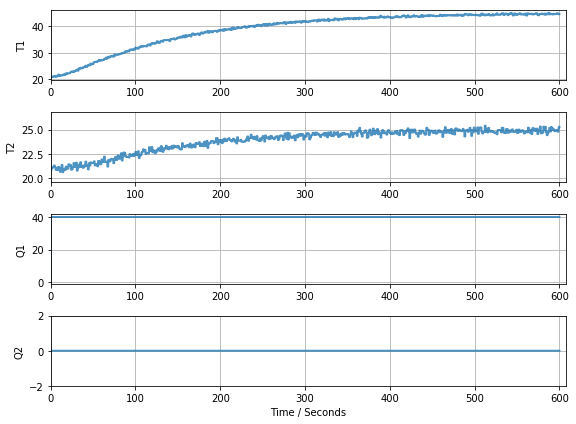

Surrogate TCLab disconnected successfully.


In [4]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

MV = 40

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    a.U1 = MV
    for t in clock(600):
        PV = a.T1         # get measurement measurement
        p.update()        # record results

## Closed Loop Control

Obviously we could go through an iterative process of guessing values for MV that cause the temperature to reach 40°C. But that's going to be slow and frustrating.  Is there a better way?

Let's create a feedback rule (i.e., 'close the loop') which turns the heater on and off, depending whether the the temperature is above or below the 40°C setpoint (SP).

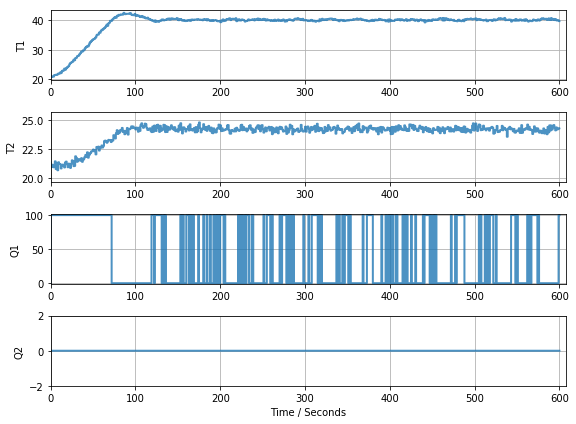

Surrogate TCLab disconnected successfully.


In [18]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

SP = 40   # setpoint

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(600):
        PV = a.T1                    # get measurement
        MV = 100 if PV <= SP else 0  # feedback control rule
        a.U1 = MV                    # apply control
        p.update()                   # update our record

## Relay Control

Relay control is perhaps the simplest form of feedback control. In this case, the manipulated variable switches back-and-forth between an 'on' and an 'off' value.  For the case where the process variable (PV) responds in the positive direction with an increase in the manipulate variable, the control rule reads

$$MV = \begin{cases} MV_{max} & \mbox{if }PV \lt SP \\ MV_{min} & \mbox{if }PV \geq SP \end{cases}$$

The following cell demonstrates the definition of a function implementing relay control, and how to apply it to the control of the temperature control lab.

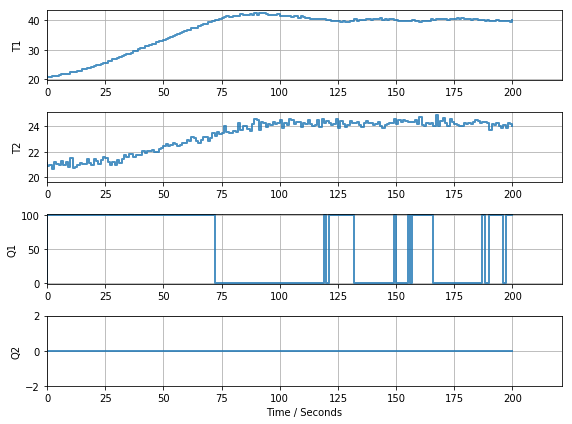

Surrogate TCLab disconnected successfully.


In [19]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

SP = 40     # setpoint

# controller function
def relay(PV, SP):
    if PV < SP:
        MV = 100
    else:
        MV = 0
    return MV

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200):
        PV = a.T1                 # get measurement
        MV = relay(PV, SP)        # control calculation
        a.U1 = MV                 # apply control
        p.update(t)               # record what happened

### Important Observations

Under relay feedback control ---

* The closed-loop temperature response reached steady state far more quickly. The improved speed of response is because the controller action is not limited to a single value as it is in the open loop case.

* The steady-state is much closer to the desired setpoint. The control can be as accurate as the measurement.

Relay control is simple and effective.  However, the drawbacks are

* While the response gets close to a steady state, it never actually settles to a single value.

* Even a small amount of measurement noise causes a lot of on/off switching of the heater power. This would be highly undesireable in large scale industrial applications.


## Proportional Control

Proportional control is again an example of a controller that only requires knowledge of the setpoint (SP) and measured process variable (PV). The value of manipulated variable is determined by

$$MV = K_p (SP - PV)$$

where $K_p$ is a constant of proportionality.

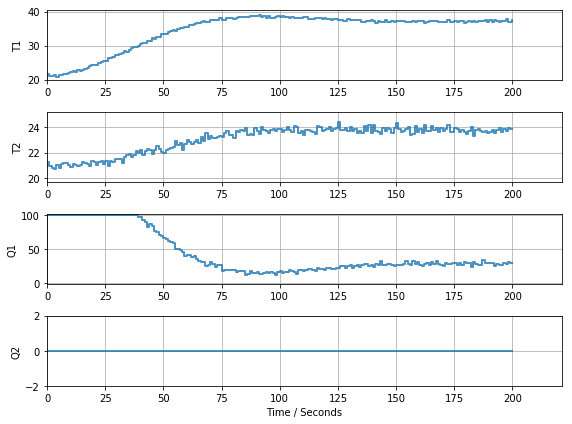

Surrogate TCLab disconnected successfully.


In [20]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

SP = 40   # setpoint

# controller function
def controller(PV, SP, Kp):
    return Kp*(SP - PV)

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200):
        PV = a.T1                     # get measurement
        MV = controller(PV, SP, 10)   # feedback control calculation
        a.U1 = MV                     # apply control
        p.update(t)                   # record what happened

### Exercises

Use this example to develop your understanding and intuition regarding proportional control. Try things like 

* Changing the gain $K_p$ to very small and very large values. What do you see?
* A cooling disturbance could be modeled by substracting a constant value from MV. How does this affect the steady state value of the controlled temperature?

### Important Observations

Proportional feedback control is simple and effective, and requires minimal knowledge of the process being controlled. The challenge is to find a value of the control constant $K_p$ that achieves the control objectives.

Drawbacks of proportional control ---

* Unless the control constant is very large, there is a steady state offset between the measured process variable and the setpoint.
* Increasing $K_p$ leads to instability and excessive control action.



## Controllers with Memory

Let's take a look at a model for a simple relay control.

In [25]:
def controller(PV, SP):
    if PV < SP:
        MV = 100
    else:
        PV < SP
        
    return MV

This worked reasonably well, but we saw that it was sensitive to measurement noise. Even a relatively small amount of measurement noise causes the manipulated variable to swing between extreme values at high frequency. Needless to say, this would be a disaster in large scale chemical plants.

A common workaround is add a small amount of hystersis to the controller. Here's an example from the Inkbird IB-16 controller that is typical of a commercial devices found in the food and pharaceutical industries.

<img src='images/Inkbird-16.png' style="float: left;padding-right:10px;"></img>
<img src='images/Inkbird-16-Manual.png' style="float: right;padding-left:30px;"></img>

The controller is modeled

$$MV_{k+1} = \begin{cases} 100 & \mbox{if }PV_k \leq SP - h \\ 0 & \mbox{if }PV_k \geq SP + h \\ MV_k\end{cases}$$

How can this be coded as a Python function?

In [26]:
def controller(PV, SP, MV, h):
    if PV < SP - h:
        MV = 100
    elif PV > SP + h:
        MV = 0
    else:
        MV = MV
        
    return MV

Now we apply the controller.

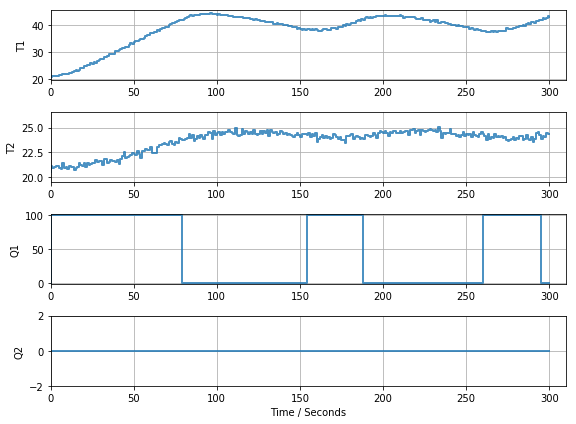

Surrogate TCLab disconnected successfully.


In [27]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

SP = 40
MV = 0

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(300, strict=False):
        PV = a.T1                         # get measurements
        MV = controller(PV, 40, MV, 2)    # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

This works ok, but notice how we have to keep track of the last value of MV?  This is an example of controller that requires knowledge of what has happened in the past. In other words, the controller has some state variables. 

**State** is the minimal amount of information needed (in addition to exogenous inputs) to predict response of a system.

State can get very complicated! In this case the state consists of the current value of MV, but in more complex controllers the state might include past measurements, past manipulated variables, and variables associated with the control algorithm.

## Python Yield Statement

The current controller reads ...

In [29]:
def controller(PV, SP, MV, h):
    if PV < SP - h:
        MV = 100
    elif PV > SP + h:
        MV = 0
    else:
        MV = MV
    return MV

The trouble with this implementation is the MV is pushed back and forth with the calling program as a means of maintaining state.  This is where the Python `yield` statement is very useful. The yield statement provides a way of returning a sequence of values. Functions that employ yield are called generators.

In [38]:
def mygen(N):
    for k in range(0,N):
        yield 2*k
        
mygen(10)

<generator object mygen at 0x11a4730f8>

Generators can be used to create loops.

In [37]:
for k in mygen(5):
    print(k)

0
2
4
6
8


Generators can also accept input.  This opens up a whole world of interesting applicatons. In the case we can call the function a **co-routine**.

In [74]:
def relay(SP, h):
    MV = 0
    while True:
        PV = yield MV
        if PV < SP - h:
            MV = 100
        elif PV > SP + h:
            MV = 0
        else:
            MV = MV
        
        
controller = relay(40, 2)
controller

<generator object relay at 0x11abb3570>

We see that 

In [76]:
controller = relay(40, 2)     # create the controller
controller.send(None)      # initialize the controller

for temp in range(30,45):
    print(temp, controller.send(temp))
    
for temp in range(45,30,-1):
    print(temp, controller.send(temp))

30 100
31 100
32 100
33 100
34 100
35 100
36 100
37 100
38 100
39 100
40 100
41 100
42 100
43 0
44 0
45 0
44 0
43 0
42 0
41 0
40 0
39 0
38 0
37 100
36 100
35 100
34 100
33 100
32 100
31 100


## Implementing Relay Control with Hysteresis

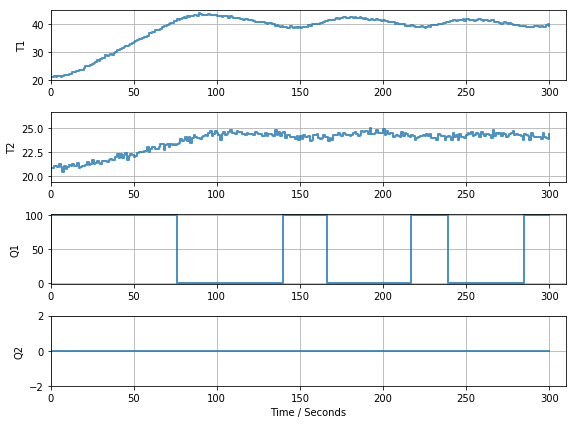

Surrogate TCLab disconnected successfully.


In [3]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

def relay(h):
    MV = 0
    while True:
        PV, SP = yield MV
        if PV < SP - h:
            MV = 100
        elif PV > SP + h:
            MV = 0
        else:
            MV = MV

SP = 40

controller = relay(1)
controller.send(None)

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(300, strict=False):
        PV = a.T1                         # get measurements
        MV = controller.send([PV,SP])    # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

## Controlling Multiple Process Variables

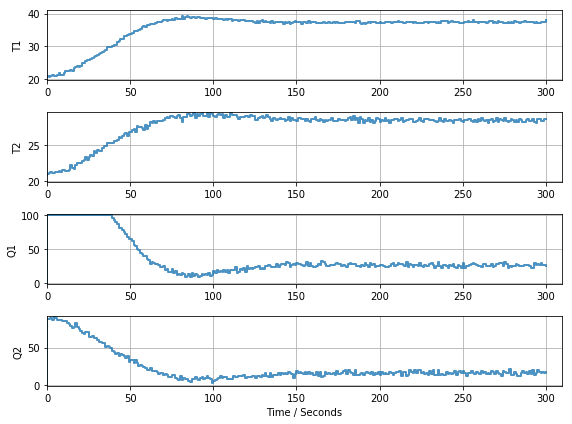

Surrogate TCLab disconnected successfully.


In [4]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

def relay(h):
    MV = 0
    while True:
        PV, SP = yield MV
        if PV < SP - h:
            MV = 100
        elif PV > SP + h:
            MV = 0
        else:
            MV = MV

def proportional(Kp):
    MV = 0
    while True:
        PV, SP = yield MV
        MV = Kp*(SP - PV)

controller1 = proportional(10)
controller1.send(None)

controller2 = proportional(10)
controller2.send(None)

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(300, strict=False):
        a.U1 = controller1.send([a.T1,40])
        a.U2 = controller2.send([a.T2,30])
        p.update(t)